## Generative Adversarial Neural Networks

In the following we look at training a Generative Adversial Neural Network on the MNIST data set in order to generate images of hand-written images that are indistinguishable from the ones used to train the network.

The general idea behind Generative Adversial Neural Networks (GANs) is that you train two models, one which generates the images given random noise as the input, and another the desciminator, to destinguish between real examples and the generated one. 

To do this we first train the descriminator, a Convolutional Neural Network, on a number of real and fake images in order to intialise the model with weights so that it can learn what a real and fake image looks like. Once this is done, we then stack the models together to produce a GAN so that the generator part of the model can be trained. The weights in the descriminator are frozen, and noisy images are generated by the generator, which are then pushed through the descriminator to determine if the generated images are real or not. If the generated image is deemed to be fake, the weights in the generator are updated via backpropagation so that it can produce a more realistic image. The aim of the generator it to ultimately fool the descriminator into thinking the image generated is real.

In [55]:
# Load libraries

import numpy as np
import keras.models as models
from keras.layers import Input, merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras
from keras.models import Model
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from tqdm import tqdm

%matplotlib inline

In [56]:
# Load Mnist data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


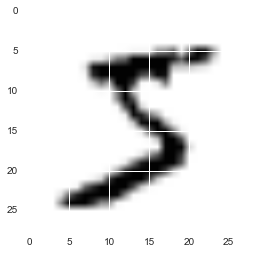

Image shape:  (28, 28, 1)


In [57]:
plt.imshow(X_train[0].reshape(28, 28))
plt.show()
print 'Image shape: ', X_train[0].shape

In [58]:
# Generative model

g_input = Input(shape=[100]) # Specify input layer of 100 random inputs

# First layer comprises of 200*14*14 = 39,200 nodes with weights initialied from the normal distribution.
H = Dense(200*14*14, init='glorot_normal')(g_input)
# Normalize the activations of the layer at each batch, i.e. applies a transformation that maintains 
# the mean activation close to 0 and the activation standard deviation close to 1.
H = BatchNormalization(mode = 2)(H)
# Activation for first layer will be the relu activation function which sets negative pixel values to zero
H = Activation('relu')(H)
# Reshape so we have 200 'images' each 14X14 pixels
H = Reshape( [14, 14, 200] )(H)
# Upsize the image to build a larger image using a an upsampling factor of 2 for both rows and columns - 
# repeating the rows and columns of the data. This will give an output of shape of (28 X 28 X ?), which is ultimately
# the dimentions we are looking for as the final output of the generator.
H = UpSampling2D(size = (2, 2))(H)
# Add convolution layer using 100 filters, each 3X3 in size to convolve over the upsampled images.
# Intialise filter using values from the normal distribution with border mode set to 'same' so that the input
# size is equal to the output size - this is done by padding the outside of the image with zeros.
H = Convolution2D(3, 3, 100, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode = 2)(H)
H = Activation('relu')(H)
# Add second convolutional layer using 50 filters, each 3X3.
H = Convolution2D(3, 3, 50, border_mode='same', init='glorot_uniform')(H)
H = BatchNormalization(mode = 2)(H)
H = Activation('relu')(H)
# Add third convolutional layer with filters such that the output image size is (28 X 28 X 1). This is done by only
# using one filter and setting border mode equal to 'same'.
H = Convolution2D(1, 1, 1, border_mode='same', init='glorot_uniform')(H)
# Use the sigmoid activation in the final layer so that the values of the pixels are between 0 and 1 - the same range
# of pixels as the real images.
g_V = Activation('sigmoid')(H)
# Generate model with input and model output
generator = Model(g_input, g_V)
# To evaluate the weights in the networks we must specify the loss function, and to optimise the weights we must
# specify the optimiser.  
generator.compile(loss ='binary_crossentropy', optimizer = Adam(lr=1e-3))
generator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 100)           0                                            
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 39200)         3959200     input_10[0][0]                   
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 39200)         78400       dense_9[0][0]                    
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 39200)         0           batchnormalization_13[0][0]      
___________________________________________________________________________________________

In [59]:
# Discriminative model

# Define input shape of the model
d_input = Input(shape = (28, 28, 1))
# The first convolutional layer comprises of 256 features, each of size 5X5 which convolve over the input image 
# using a stride of 2. The border mode has been set to 'same' so that the output shape is the same as the input
# shape. The activation function used for the convolution layer is Relu, which makes all pixel outputs positive.
H = Convolution2D(256, 5, 5, subsample = (2, 2), border_mode = 'same', activation='relu')(d_input)
# Another activation function is then applied, similar to the Relu function but instead of converting negative values 
# to zero, it multplies the input by some small number - in this case 0.2. This fixes the dying Relu problem, which 
# causes neurons to die, or never activate across the entire training set.
H = LeakyReLU(0.2)(H)
# Dropout sets a fraction of the input/output values to zero, which prevents the network from over-fitting.
H = Dropout(0.25)(H)
# Add sencond convolution layer that uses 512 filters of size 5X5.
H = Convolution2D(512, 5, 5, subsample=(2, 2), border_mode = 'same', activation='relu')(H)
H = LeakyReLU(0.2)(H)
H = Dropout(0.25)(H)
# Flatten matrix into one long vector for input into the network
H = Flatten()(H)
# Add connected layer with 256 neurons
H = Dense(256)(H)
H = LeakyReLU(0.2)(H)
H = Dropout(0.25)(H)
# The final layer or output layer consists of two neurons which has the activation softmax. The softmax function 
# squashes a K-dimentional vector z of arbitrary real values, to a K-dimentional vector of real values between 
# 0 and 1 that sum to 1. The output of the softmax function will be the probability distribution over the 
# different classes, in this case whether the input image is real or fake.
d_V = Dense(2, activation = 'softmax')(H)
# Generate model with input and model output
discriminator = Model(d_input, d_V)
# Compile model, specifying loss function and optimiser
discriminator.compile(loss='categorical_crossentropy', optimizer = 'adam')
discriminator.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_11 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_20 (Convolution2D) (None, 14, 14, 256)   6656        input_11[0][0]                   
____________________________________________________________________________________________________
leakyrelu_7 (LeakyReLU)          (None, 14, 14, 256)   0           convolution2d_20[0][0]           
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 14, 14, 256)   0           leakyrelu_7[0][0]                
___________________________________________________________________________________________

Once the discriminative model is built and trained we want to freeze the weights of the model so they are not changed once the combined model has been stacked and trained.

In [60]:
# Function that freezes the weights in each layer of the discriminator
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [61]:
# Build stacked GAN model, combining the generator and descriminator

# Freeze weights for stacked training
make_trainable(discriminator, False)
# Define input of combined model
gan_input = Input(shape=[100])
# Input into the generator model to generate an image
H = generator(gan_input)
# Input generated image into the descriminator to determine if it is real or fake
gan_V = discriminator(H)
# Combine stacked model using input and the output of descriminator
GAN = Model(gan_input, gan_V)
# Compile model
GAN.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_12 (InputLayer)            (None, 100)           0                                            
____________________________________________________________________________________________________
model_10 (Model)                 (None, 28, 28, 1)     4218972     input_12[0][0]                   
____________________________________________________________________________________________________
model_11 (Model)                 (None, 2)             0           model_10[1][0]                   
Total params: 4218972
____________________________________________________________________________________________________


In [62]:
# Pre-train the discriminator network using 50,000 images from the dataset and 50,000 images of noise, generated
# from the untrained generator.

# Make descriminator trainable
make_trainable(discriminator, True)
# 50,000 original images
gen_train = X_train[np.random.randint(0, X_train.shape[0], size = 50000)]
# Generate 50,000 noisy images
noise_gen = np.random.uniform(0, 1, size = [50000, 100])
generated_images = generator.predict(noise_gen)
# Combine noisy images and original images 
X = np.concatenate((gen_train, generated_images))
# Create empty classification list to indentify real images from noise
y = np.zeros([100000, 2])
# Generate labels
y[:50000,1] = 1
y[50000:,0] = 1
# Here we need to set each layer in the descriminator so that it is trainable again.
make_trainable(discriminator, True)
# Train descriminator
discriminator.fit(X, y, nb_epoch = 1, batch_size = 32, verbose = 1)

Epoch 1/1
100000/100000 [==============================] - 4082s - loss: 0.0039      

In [1]:
# Function to plot generated images
def plot_gen(n_ex = 16, dim = (4,4), figsize = (10,10) ):
    noise = np.random.uniform(0, 1, size = [n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        img = generated_images[i].reshape(28, 28)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()


  0%|          | 0/250 [00:00<?, ?it/s]
Exception in thread Thread-17:
Traceback (most recent call last):
  File "/Users/jayecribb/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/jayecribb/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/jayecribb/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|█████████▉| 249/250 [1:37:20<00:23, 23.24s/it]

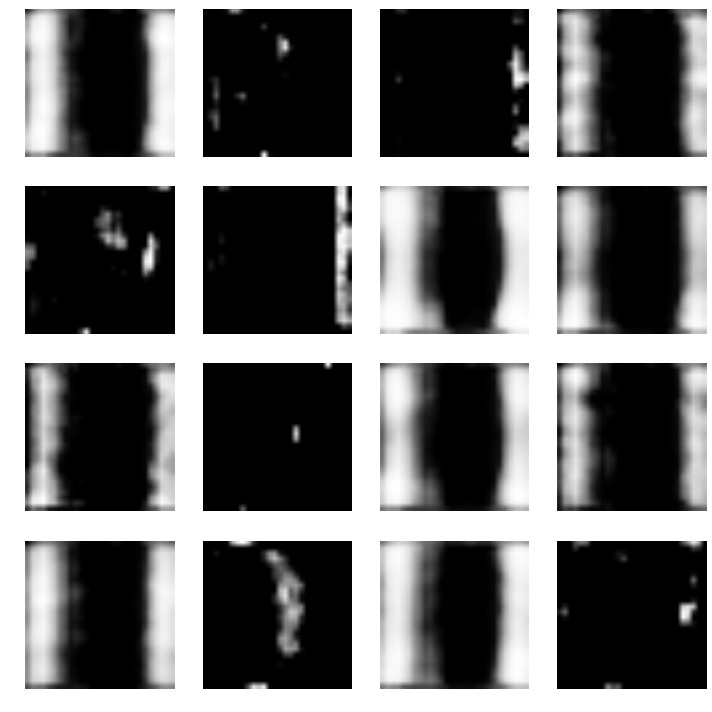


100%|██████████| 250/250 [1:37:46<00:00, 24.01s/it]


In [66]:
# Train descriminator and GAN, plotting generated images on the last epoch.

for epoch_ in tqdm(range(250)):
    
    # Descriminator images
    image_desc = X_train[np.random.randint(0, X_train.shape[0], size = 64)]
    noise_desc = np.random.uniform(0, 1, size = [64,100])
    gen_noise = generator.predict(noise_desc)
    
    # Train descriminator
    X = np.concatenate((image_desc, gen_noise))
    y = np.zeros([128, 2])
    y[:64,1] = 1
    y[64:,0] = 1
    make_trainable(discriminator, True)
    discriminator.train_on_batch(X, y)
    
    # Train GAN
    noise_gan = np.random.uniform(0, 1, size=[64, 100])
    y2 = np.zeros([64,2])
    y2[:,1] = 1

    make_trainable(discriminator, False)
    GAN.train_on_batch(noise_gan, y2)
    
    if epoch_ == 249:
        plot_gen()    

GAN needs a lot more training and optimisation (alter learning rates) in order to produce images that look like hand-written digits.

In [2]:
plot_gen_gen()

NameError: global name 'np' is not defined